In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


class AdalineGD(object):
    
    def __init__(self,eta=0.01,n_iter = 10):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self,X,Y):
        self.w_ = np.zeros(X.shape[1]+1)
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = y-output
            self.w_[1:] += self.eta*X.T.dot(errors)
            self.w_[0] += self.eta*errors.sum()
            cost = (errors**2).sum()/2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self,X):
        return np.dot(X,self.w_[1:])+ self.w_[0]
    
    def activation(self,X):
        return self.net_input(X)
    
    
    def predict(self,X):
        return np.where(self.activation(X) > 0.0, 1, -1)
    

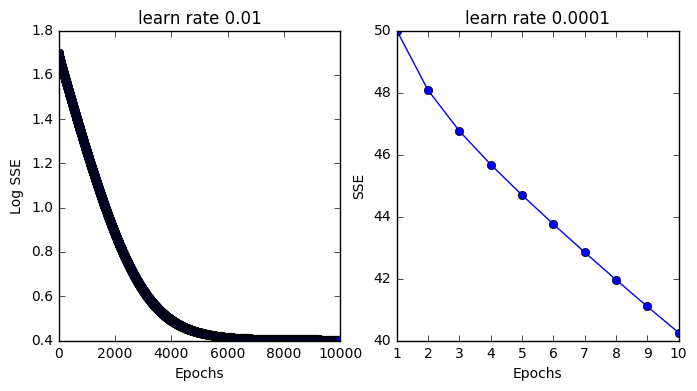

In [3]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
#df.to_csv('iris.data')
#df = pd.read_csv('iris.csv')
y = df.iloc[0:100,4].values
y = np.where(y == 'Iris-setosa',-1,1);
x = df.iloc[0:100,[0,2]].values

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ada1 = AdalineGD(n_iter=10000, eta=0.000005).fit(x, y)
ax[0].plot(range(1, len(ada1.cost_) + 1),np.log10(ada1.cost_), marker='o')
#ax[0].plot(range(1, len(ada1.cost_) + 1),ada1.cost_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Log SSE')
ax[0].set_title('learn rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(x, y)
ax[1].plot(range(1, len(ada2.cost_) + 1),ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('SSE')
ax[1].set_title('learn rate 0.0001')

plt.show()

对特征归一化

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X,y,classifier,resolution=0.02):
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min,x1_max = X[:,0].min() - 1,X[:,0].max() +1
    x2_min,x2_max = X[:,1].min() - 1,X[:,1].max() +1
    
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                         np.arange(x2_min,x2_max,resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z,alpha=0.4,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl,0],y=X[y == cl, 1],
                   alpha=0.8, c=cmap(idx),
                   marker=markers[idx], label=cl)

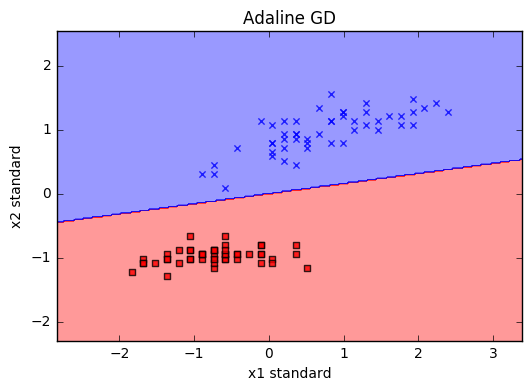

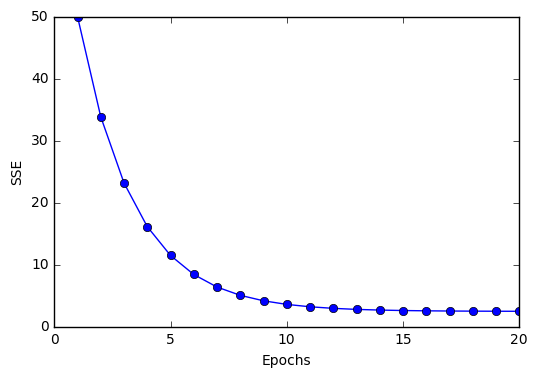

In [12]:
X_std = np.copy(x)
X_std[:,0] = (X_std[:,0] - X_std[:,0].mean()) / X_std[:,0].std()
X_std[:,1] = (X_std[:,1] - X_std[:,1].mean()) / X_std[:,1].std()
ada = AdalineGD(eta=0.01,n_iter = 20).fit(X_std,y)
plot_decision_regions(X_std,y,ada,resolution=0.02)
plt.title('Adaline GD')
plt.xlabel('x1 standard')
plt.ylabel('x2 standard')
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('SSE')
plt.show()


下面使用的是SGD来学习Adaline
---

In [13]:
from numpy.random import seed

class AdalineSGD(object):
    
    '''
    参数：学习率，迭代次数epochs,是否打乱数据
    self.errors_ 记录每轮迭代后的误判个数
    self.w_ 记录学习到的权重
    cost_: 每轮迭代后的误差
    '''
    
    def __init__(self,eta = 0.01,n_iter=10,shuffle=True,random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.w_initialized = False
        if(random_state):
            seed(random_state)
    
    def fit(self,X,y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X,y = self._shuffle(X,y)
            cost = []
            for xi,target in zip(X,y):
                cost.append(self._update_weights(xi,target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self,X,y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
            if y.ravel().shape[0] > 1:
                for xi, target in zip(X, y):
                    self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

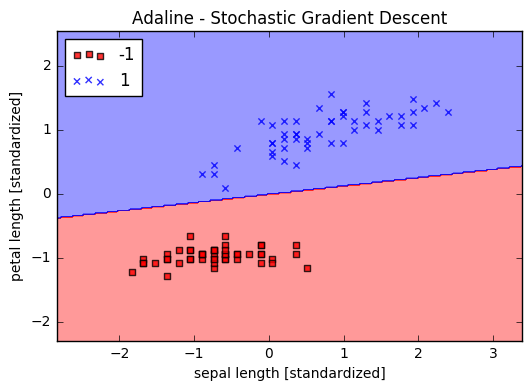

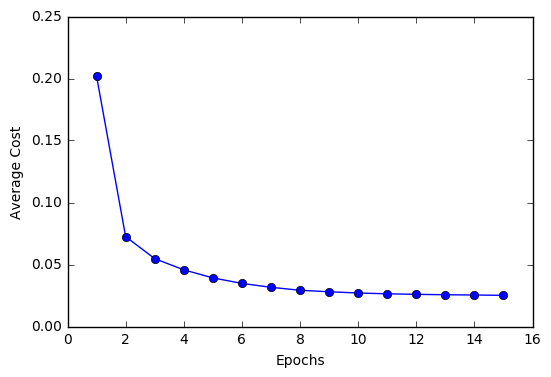

In [16]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()

In [1]:
import numpy as np

In [5]:
x = np.arange(10)
# dfasf 

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# TIme